Project 2: Object Detection

In [1]:
# imports

import random
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import patches
from torch.utils.data import random_split
from torchvision import transforms

torch.manual_seed(265)
torch.set_default_dtype(torch.double)

In [2]:
path = 'datasets/'
det_train_path = path + 'detection_train.pt'
det_val_path = path + 'detection_val.pt'
det_test_path = path + 'detection_test.pt'
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # change this to cuda if ya want lol

# Model parameters
EPOCHS = 7  # Epochs
BATCH_SIZE = 64  # Batch size
KEEP_PROB = 1  # Dropout

#Optimizer parameters
LR = 1e-3  # Learning Rate
BETAS = (0.9, 0.999)  # ADAM Momentum and RSMProp Betas
EPSILON = 1e-8  # ADAM Vanishing and Exploding Gradients
LAMBDA = 1e-4  # L2 Regularization

models = []
model_names = []
loss_train_list = []
loss_val_list = []

In [3]:
detection_train_data = torch.load(det_train_path)
detection_val_data = torch.load(det_val_path)
detection_test_data = torch.load(det_test_path)

Dataset Normalization:

In [4]:
# Train normalization
train_all = [x for x, _ in detection_train_data]
trainto_one_tensor = torch.stack(train_all)

mean_train = trainto_one_tensor.mean()
std_train = trainto_one_tensor.std()

detection_train_data.transform = transforms.Normalize(mean_train, std_train)


# Val normalization
val_all = [x for x, _ in detection_val_data]
val_to_one_tensor = torch.stack(val_all)

mean_val = val_to_one_tensor.mean()
std_val = val_to_one_tensor.std()

detection_val_data.transform = transforms.Normalize(mean_val, std_val)


# Test normalization
test_all = [x for x, _ in detection_test_data]
test_to_one_tensor = torch.stack(test_all)

mean_test = test_to_one_tensor.mean()
std_test = test_to_one_tensor.std()

detection_test_data.transform = transforms.Normalize(mean_test, std_test)

Dataset Familiarization:

In [5]:
def print_random_img(data):
    x, y = data.__getitem__(random.randint(0, len(data)))
    # (C, H, W)
    tensor_image = transforms.ToPILImage()(x).convert("RGB")
    plt.imshow(tensor_image)
    plt.show()

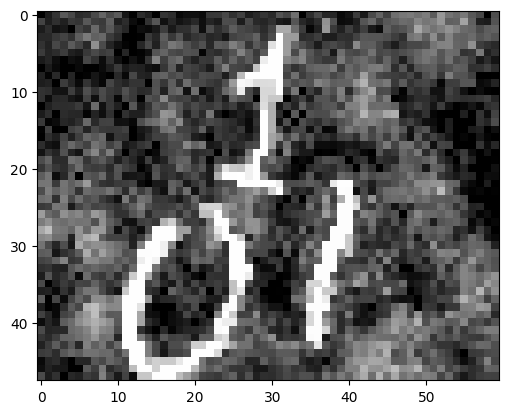

In [6]:
print_random_img(detection_train_data)

Three Convolutional Architectures based of LeNet5:

In [7]:
# Standard Convolutional LeNet5 Model:
class Net01(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=120, out_channels=84, kernel_size=3),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer5 = torch.nn.Sequential(
            nn.Conv2d(in_channels=84, out_channels=7, kernel_size=(2, 4)),
        )

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.layer5(y)
        y = y.permute(0, 2, 3, 1)

        return y

In [8]:
# Shallow Convolutional LeNet5 Model:
class Net02(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4, 6)),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer5 = torch.nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1)),
        )

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.layer5(y)
        y = y.permute(0, 2, 3, 1)

        return y

In [9]:
# Deep Convolutional LeNet5 Model:
class Net03(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=240, kernel_size=3),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=240, out_channels=360, kernel_size=3),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer5 = torch.nn.Sequential(
            nn.Conv2d(in_channels=360, out_channels=420, kernel_size=3),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer6 = torch.nn.Sequential(
            nn.Conv2d(in_channels=420, out_channels=560, kernel_size=(2, 4)),
            nn.ReLU(),
            torch.nn.Dropout(p=1 - KEEP_PROB)
        )
        self.layer7 = torch.nn.Sequential(
            nn.Conv2d(in_channels=560, out_channels=560, kernel_size=(1, 1)),
        )

    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = self.layer3(y)
        y = self.layer4(y)
        y = self.layer5(y)
        y = self.layer6(y)
        y = self.layer7(y)
        y = y.permute(0, 2, 3, 1)

        return y

In [10]:
def myLoss(output, target):
    # Uses BinaryClassification as a  loss function to train the network to recognize if there is a number in the cell or not
    prob = output[:, :1]
    probTarget = target[:, :1]
    loss_fn = nn.BCEWithLogitsLoss()
    loss_prob = loss_fn(prob, probTarget)

    # Creates boolean mask based of if there is a number in the cell and filters out all labels where there is no number
    outputShape = output.shape[1]
    maskOutput = target[:, :1].eq(1).repeat(1, outputShape)
    maskTarget = target[:, :1].eq(1).repeat(1, 6)
    output = torch.masked_select(output, maskOutput)
    target = torch.masked_select(target, maskTarget)
    output = output.reshape(int(output.shape[0] / outputShape), outputShape)
    target = target.reshape(int(target.shape[0] / 6), 6)

    # If there is a number in the cell it uses MeanSquaredError as a loss function to train the network to find the number's center and its bounding box
    bb = output[:, 1:5]
    bbTarget = target[:, 1:5].to(dtype=torch.double)
    loss_fn = nn.MSELoss()
    loss_bb = loss_fn(bb, bbTarget)

    # If there is a number in the cell it uses CrossEntropy as a loss function to train the network to classify the numbers
    clas = output[:, 5:]
    clasTarget = target[:, 5].to(dtype=torch.long)
    loss_fn = nn.CrossEntropyLoss()
    loss_clas = loss_fn(clas, clasTarget)

    return loss_prob + loss_bb + loss_clas

Training of the models:

In [11]:
def train(n_epochs, optimizer, model, train_loader, train_mode):
    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device, dtype=torch.double)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = 0
            for x in range(2):
                for y in range(3):
                    loss += myLoss(outputs[:, x, y, :], labels[:, x, y, :])

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
            datetime.now().time(), epoch, loss_train / n_batch))
    train_mode.append(losses_train)

In [12]:
train_loader = torch.utils.data.DataLoader(detection_train_data, batch_size=BATCH_SIZE, shuffle=True)
model01 = Net01().to(device=device)
optimizer = optim.Adam(model01.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
train(EPOCHS, optimizer, model01, train_loader, loss_train_list)
models.append(model01)
model_names.append("LeNet Standard")

09:20:03.134607  |  Epoch 1  |  Training loss 8.04562
09:20:13.072124  |  Epoch 2  |  Training loss 7.32372
09:20:22.681992  |  Epoch 3  |  Training loss 6.82792
09:20:32.051178  |  Epoch 4  |  Training loss 6.28328
09:20:41.459750  |  Epoch 5  |  Training loss 5.82814
09:20:51.084445  |  Epoch 6  |  Training loss 5.53797
09:21:00.370558  |  Epoch 7  |  Training loss 5.34697


In [13]:
train_loader = torch.utils.data.DataLoader(detection_train_data, batch_size=BATCH_SIZE, shuffle=True)
model02 = Net02().to(device=device)
optimizer = optim.Adam(model02.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
train(EPOCHS, optimizer, model02, train_loader, loss_train_list)
models.append(model02)
model_names.append("LeNet Shallow")

09:21:04.968253  |  Epoch 1  |  Training loss 10.71311
09:21:09.304101  |  Epoch 2  |  Training loss 8.12783
09:21:13.741749  |  Epoch 3  |  Training loss 8.07282
09:21:18.792772  |  Epoch 4  |  Training loss 7.98140
09:21:23.386498  |  Epoch 5  |  Training loss 7.69154
09:21:28.204375  |  Epoch 6  |  Training loss 7.37003
09:21:32.688807  |  Epoch 7  |  Training loss 7.02846


In [14]:
train_loader = torch.utils.data.DataLoader(detection_train_data, batch_size=BATCH_SIZE, shuffle=True)
model03 = Net03().to(device=device)
optimizer = optim.Adam(model03.parameters(), lr=LR, betas=BETAS, eps=EPSILON, weight_decay=LAMBDA)
train(EPOCHS, optimizer, model03, train_loader, loss_train_list)
models.append(model03)
model_names.append("LeNet Deep")

09:23:10.708994  |  Epoch 1  |  Training loss 9.97300
09:24:48.396788  |  Epoch 2  |  Training loss 7.30924
09:26:23.808450  |  Epoch 3  |  Training loss 6.70027
09:27:59.978872  |  Epoch 4  |  Training loss 6.13920
09:29:36.278638  |  Epoch 5  |  Training loss 5.76632
09:31:14.523774  |  Epoch 6  |  Training loss 5.41164
09:32:52.088939  |  Epoch 7  |  Training loss 5.17869


Define IoU:

In [15]:
def intersection_over_union(pred_box: torch.tensor, label_box: torch.tensor):
    box1_x1 = pred_box[..., 0:1] - pred_box[..., 2:3] / 2
    box1_y1 = pred_box[..., 1:2] - pred_box[..., 3:4] / 2
    box1_x2 = pred_box[..., 0:1] + pred_box[..., 2:3] / 2
    box1_y2 = pred_box[..., 1:2] + pred_box[..., 3:4] / 2

    box2_x1 = label_box[..., 0:1] - label_box[..., 2:3] / 2
    box2_y1 = label_box[..., 1:2] - label_box[..., 3:4] / 2
    box2_x2 = label_box[..., 0:1] + label_box[..., 2:3] / 2
    box2_y2 = label_box[..., 1:2] + label_box[..., 3:4] / 2

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [16]:
def find_highest_acc(output):
    output = output.squeeze()
    classes = [x.item() for x in output]

    classes = classes[5:]
    index = (classes.index(max(classes)))
    return index


def get_vals(tensor: torch.tensor):
    tens = tensor[1:5].clone().detach()
    return torch.tensor(
        [(int(tens[0] * 60)) - int((tens[2] / 2) * 60),
         int(tens[1] * 48) - int((tens[3] / 2) * 48),
         int(tens[2] * 60),
         int(tens[3] * 48)],
        dtype=torch.int)

Define Accuracy:

In [ ]:
# Correct is defined as correct classification and IoU > 50% for a bounding box
def compute_acc(model, loader):
    correct = 0.
    total = 0.
    with torch.no_grad():
        model.eval()
        for imgs, labels in loader:
            imgs = imgs.to(device=device, dtype=torch.double)
            labels = labels.to(device=device)
            output = model(imgs)
            for x in range(2):
                for y in range(3):
                    tensor_ = output[:, x, y, :].squeeze()
                    label_box = labels[:, x, y, :].squeeze()
                    IoU = intersection_over_union(get_vals(label_box), get_vals(tensor_))
                    tensor_[5:] = torch.nn.functional.softmax(tensor_[5:].clone(), dim=0)
                    true_class = int(label_box[-1].item())
                    predicted_class = find_highest_acc(tensor_)
                    if true_class == predicted_class and IoU > 0.5:
                        correct += 1
                        total += 1
                    else:
                        total += 1

    return ((correct + IoU) / total).item()

Model Performance and Accuracy:

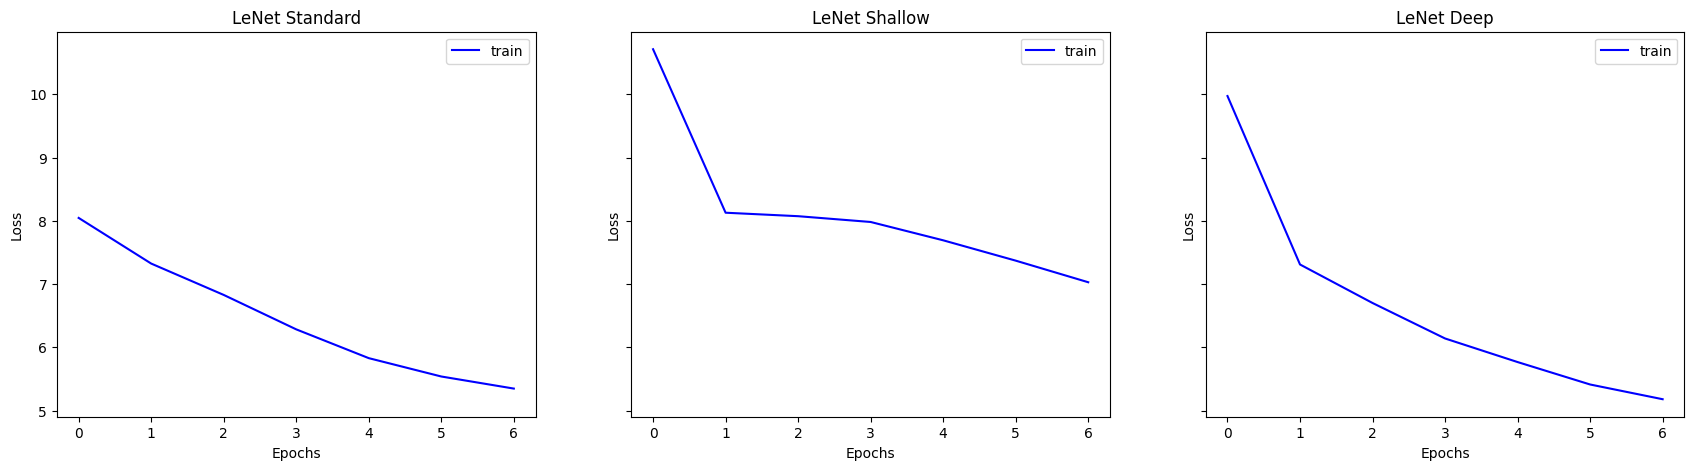

In [17]:
n_model = len(models)

fig, axes = plt.subplots(1, n_model, figsize=(7 * n_model, 5), sharey=True, squeeze=False)

for l_train, name, ax in zip(loss_train_list, model_names, axes.flat):
    ax.plot(l_train, label='train', color=random.choice(['r', 'b', 'y', 'g', 'c', 'm']))
    ax.set_title(str(name))
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

plt.show()

In [18]:
model_score = []

for i, model in enumerate(models):
    val_load = torch.utils.data.DataLoader(detection_val_data, shuffle=True)
    model_perf = compute_acc(model, val_load) * 100
    model_score.append(model_perf)
    print(f"Accuracy of {model_names[i]} is {model_perf}")

index_best_model = (model_score.index(max(model_score)))
best_model = models[index_best_model]
print(f"The best model is {model_names[index_best_model]}")

Accuracy of LeNet Standard is 3.1223083548664947
Accuracy of LeNet Shallow is 2.3040482342807924
Accuracy of LeNet Deep is 3.55297157622739
The best model is LeNet Deep


Showcasing The Best Models Performance In Object Detection:

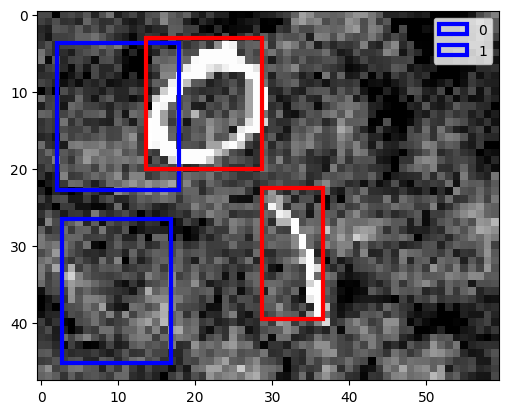

In [22]:
img, label = detection_test_data[random.randint(0, len(detection_val_data))]
img = img.to(device, dtype=torch.double)

tensor_image = transforms.ToPILImage()(img).convert("RGB")
plt.show()

best_model.eval()
output = best_model(img.unsqueeze(0))[0]
pred = torch.nn.functional.softmax(output[:,:,0].reshape(-1).clone(), dim=0).reshape(2,3,1)

fig, ax = plt.subplots(1)
ax.imshow(tensor_image)
for cell_y in range(label.shape[0]):
    for cell_x in range(label.shape[1]):
        number_in_cell = label[cell_y, cell_x, 0].item()
        number_in_cell_pred = pred[cell_y, cell_x, 0].item()
        if number_in_cell == 1.0:
            cell = label[cell_y,cell_x]
            x = cell[1].item()
            y = cell[2].item()
            w = cell[3].item()
            h = cell[4].item()
            true_bb = patches.Rectangle((cell_x * 20 + (x * 20 - (w * 20) / 2), cell_y * 24 + (y * 24 - (h * 24) / 2)), w * 20, h * 24, linewidth=3, edgecolor='r', facecolor='none')
            ax.add_patch(true_bb)
        elif number_in_cell_pred > 0.2:
            cell = output[cell_y,cell_x]
            x = cell[1].item()
            y = cell[2].item()
            w = cell[3].item()
            h = cell[4].item()
            pred_bb = patches.Rectangle((cell_x * 20 + (x * 20 - (w * 20) / 2), cell_y * 24 + (y * 24 - (h * 24) / 2)), w * 20, h * 24, linewidth=3, edgecolor='b', facecolor='none', label=str(torch.argmax(cell[5:]).item()))
            ax.add_patch(pred_bb)

plt.legend(loc='upper right')
plt.show()

In [20]:
test_load = torch.utils.data.DataLoader(detection_test_data, shuffle=True)
acc = compute_acc(best_model, test_load)
print(f"The accuracy of the best model is: {acc*100}% in object detection and classification")

The accuracy of the best model is: 3.594386940065412% in object detection and classification
